# Overview

[Script of Scripts (SoS)](https://vatlab.github.io/sos-docs/index.html#content) is a scripting language designed for the execution of workflows that involve the analysis of data in multiple languages.


It is a web-based notebook environment that allows the use of multiple scripting language in a single notebook, with data flowing freely within and across languages. SoS Notebook enables researchers to perform sophisticated bioinformatic analysis using the most suitable tools for different parts of the workflow, without the limitations of a particular language or complications of cross-language communications. If you are interested in `SoS`, you can read more about it in [this paper](https://academic.oup.com/bioinformatics/article/34/21/3768/5001386).

In this notebook, you will explore some basic functions of `sos` in the analysis of UK Biobank, based on a simulated dataset. Before you start, first make sure that the general kernel for this notebook is in SoS (on the top right corner, you can select the SoS kernel after installation), and in each cell, you should choose the correct kernel (in the scroll-down list you should see at least three options `Python`, `R`, `SoS`).

Please follow the instructions throughout this notebook and run all the cells. Add cells under each question (in `Python`, `SoS` or `markdown`) to answer.


# Intro -- set up

In [1]:
# set the kernel of this cell as SoS
print("hello world!")

hello world!


In [1]:
# set the kernel of this cell as Python3
print("hello world!")

hello world!


You see they give you the same result. So you can write in python directly in a sos cell.

# Download the toy data and preview

Before we start any analysis, let's import the packages required first.

Then please download the data under `data/toy_data.tsv` and import it in python.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # pretty plotting, similar to ggplot2
import matplotlib.pyplot as plt # base plots

import statsmodels.api as sm # similar to glm() in R
import statsmodels.formula.api as smf

from scipy.stats import norm
from scipy.stats import t
from sklearn.preprocessing import scale

If you have something reporting `No module named 'xxxx'` or `cannot import name 'xxxx'` that means it is not installed. Please refer to [this page](https://mamba.readthedocs.io/en/latest/user_guide/micromamba.html) to install the modules required under `micromamba` (you may need to restart the whole notebook process if necessary). Otherwise you can install them using `conda`.

Then we import the data using `pandas` (note that you may need to change the path to where you store the downloaded data):

In [2]:
toy_data = pd.read_table("../data/toy_data.tsv", low_memory=False)
toy_data.head()

,ID,f.131057.0.0,f.131369.0.0,f.131056.0.0,f.131368.0.0,f.31.0.0,f.33.0.0
0,801313,51.0,50.0,1993-02-09,2008-07-22,0,1958-10-12
1,959469,NaN,NaN,NaN,NaN,1,1948-01-22
2,954457,40.0,NaN,2003-08-16,NaN,0,1973-02-09
3,711984,NaN,NaN,NaN,NaN,1,1951-09-08
4,881953,NaN,50.0,NaN,2018-06-04,1,1951-01-21


You can also view it in SoS using the [Magic `%preview`](https://vatlab.github.io/sos-docs/doc/user_guide/magic_preview.html):

In [ ]:
# set the kernel of this cell as SoS
%preview -n "../data/toy_data.tsv"

# Exercise 1 - Explore the "first occurence" phenotypes

As you can see, the raw data are not very easy to understand!

The first thing you want to understand is the column names, which we can do by searching in the UK Biobank [Showcase](https://biobank.ndph.ox.ac.uk/showcase/index.cgi). For example, search `31` and then you will see it actually represents [sex](https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=31). Please read more into the data-coding of it (and other columns) and answer the following questions.

Please finish this section all in `Python3` or `markdown` cells.

***
**Question 1: how many females and males are in the toy data? What's the average age of all females now (as up to Jan-01-2024)?**

**Answer: There are 50185 males and 49815 females. The average age of all females is 64.**

In [3]:
toy_data = toy_data.rename(columns={
    'f.31.0.0': 'sex',
    'f.33.0.0': 'birthday'
})
toy_data['sex'].value_counts()

0    50185
1    49815
Name: sex, dtype: int64

In [7]:
from datetime import datetime
toy_data['birthday'] = pd.to_datetime(toy_data['birthday'])
reference_date = datetime(2024, 1, 1)
def calculate_age(row):
    age = reference_date.year - row['birthday'].year - ((reference_date.month, reference_date.day) < (row['birthday'].month, row['birthday'].day))
    return age

toy_data['age'] = toy_data.apply(calculate_age, axis=1)
average_age_females = toy_data[toy_data['sex'] == 1]['age'].mean()
average_age_females

63.58542607648299

***

Now you should know what the column names are. Then let's take a look at the phenotype columns. The easiest place to start is with the UK Biobank's pre-processed "[first occurence](https://biobank.ndph.ox.ac.uk/showcase/refer.cgi?id=593)" disease phenotypes. These phenotypes have been generated from all the sources listed above, and are encoded by 3-character [ICD-10 codes](https://icd.who.int/browse10/2019/en), which are a widely used international standard for cataloguing human diseases. Each disease (specified by an ICD-10 code) is encoded in two fields: one with the data source where the first occurence was observed (encoding described [here](https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=2171)), and another with the date when that event happened.

For example, if you search for "transient ischaemic attack" reveals that field 131056 contains the date of the first reported diagnosis and 131057 contains the source where the diagnosis was reported. Let's first rename the columns containing the first reported occurrence source and date for transient ischaemic attack (TIA) and stroke into human readable names and use those to explore the data.

In [8]:
toy_data = toy_data.rename(columns={
    'f.131057.0.0': 'TIA_first_occurrence',
    'f.131369.0.0': 'stroke_first_occurrence'
})

# Checking what variable TIA_first_occurrence contains
#   the variable includes codes for the diagnosis source and is missing (NA) for sampled without diagosis
#   (40=Hospital admissions data only, 50=Self-report only, 51=Self-report and other source(s))
toy_data['TIA_first_occurrence'].value_counts(dropna=False)

NaN     63000
50.0    17000
51.0    10067
40.0     9933
Name: TIA_first_occurrence, dtype: int64

Let's now count many cases of TIA and stroke are there and make a bar plot. First, this code counts the number of TIA and stroke cases (i.e. individuals with non-missing data in first occurrences for TIA and stroke). Then it reformats these numbers into a "long" format suitable for plotting using the function pivot_longer (which is explained in the comments of the code). Finally, it plots this data as a bar graph using the plotting function “ggplot" from the package ggplot2 (again, look at the comments to see how this plotti). Next, we want to calculate how many TIA and stroke cases are there.

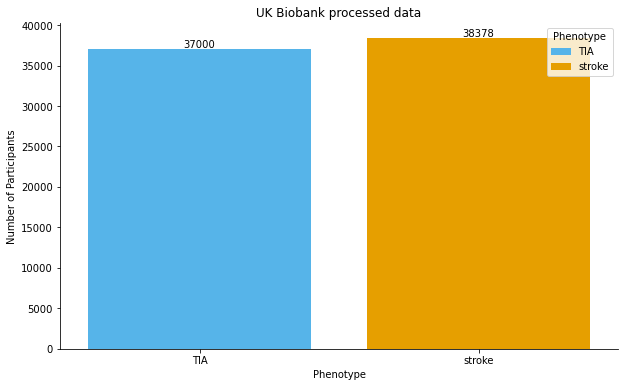

In [10]:
# Extract the number of participants with a non-missing value for the first occurrence
tmp = {
    'TIA': toy_data['TIA_first_occurrence'].notna().sum(),
    'stroke': toy_data['stroke_first_occurrence'].notna().sum()
}

# Convert the dictionary to a DataFrame
tmp = pd.DataFrame(list(tmp.items()), columns=['phenotype', 'number_of_participants'])

# tmp = pd.DataFrame(list(tmp.items()), columns=['phenotype', 'number_of_participants']).set_index('phenotype')

# Define the colors for the bars
colors = ["#56B4E9", "#E69F00"]

# Plot the totals using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=tmp, x='phenotype', y='number_of_participants', hue='phenotype', dodge=False, palette=colors, saturation=1)
sns.despine()

for x in range(0,2):
    ax.bar_label(ax.containers[x])

plt.title('UK Biobank processed data')
plt.xlabel('Phenotype')
plt.ylabel('Number of Participants')
plt.legend(title='Phenotype')

plt.show()

As we noted above, TIA and stroke are related, but distinct, vascular diseases. It is generally accepted to be extremely rare for a person to have both of these diseases. Let's see what we find in our data.

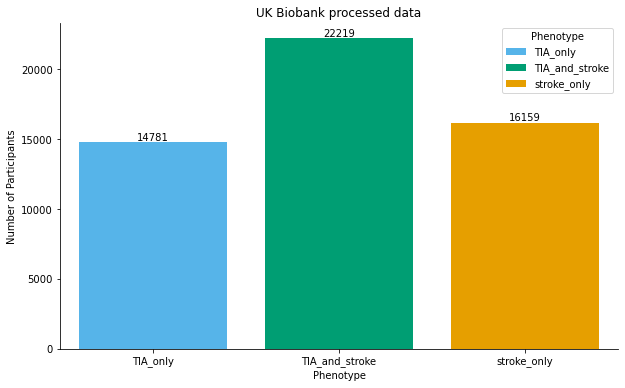

In [12]:
# Extract the three combinations: only TIA, both TIA & stroke, and only stroke
tmp = {
    'TIA_only': ((toy_data['TIA_first_occurrence'].notna()) & (toy_data['stroke_first_occurrence'].isna())).sum(),
    'stroke_only': ((toy_data['stroke_first_occurrence'].notna()) & (toy_data['TIA_first_occurrence'].isna())).sum(),
    'TIA_and_stroke': (toy_data['TIA_first_occurrence'].notna() & toy_data['stroke_first_occurrence'].notna()).sum()
}

# Convert the dictionary to a DataFrame
tmp = pd.DataFrame(list(tmp.items()), columns=['phenotype', 'number_of_participants'])

# Set the order for plotting
tmp['phenotype'] = pd.Categorical(tmp['phenotype'], categories=['TIA_only', 'TIA_and_stroke', 'stroke_only'], ordered=True)

# Define the colors for the bars
colors= ["#56B4E9","#009E73","#E69F00"]

# Plot the totals using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=tmp, x='phenotype', y='number_of_participants', hue='phenotype', dodge=False, palette=colors, saturation=1)
sns.despine() 

for x in range(0,3):
    ax.bar_label(ax.containers[x])

plt.title('UK Biobank processed data')
plt.xlabel('Phenotype')
plt.ylabel('Number of Participants')
# plt.legend(title='Phenotype')
ax.legend(title='Phenotype')
plt.show()

Now let's take a look at the dates when these diagnoses were recorded in the UK Biobank data. 


In [13]:
if 'f.131056.0.0' in toy_data.columns and 'f.131368.0.0' in toy_data.columns:  # Check if the columns exist to prevent errors on rerun
    toy_data.rename(columns={
        'f.131056.0.0': 'TIA_date_first_occurrence',
        'f.131368.0.0': 'stroke_date_first_occurrence'
    }, inplace=True)
    print("Columns renamed!")
else:
    print("Columns have already been renamed!")

Columns renamed!


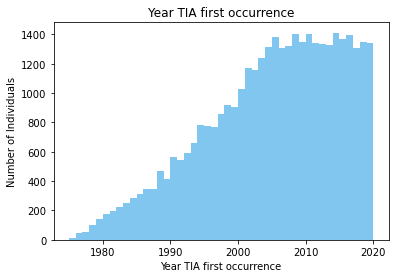

In [14]:
# Extract years from dates
toy_data['TIA_year_first_occurrence'] = pd.to_datetime(toy_data['TIA_date_first_occurrence']).dt.year
toy_data['stroke_year_first_occurrence'] = pd.to_datetime(toy_data['stroke_date_first_occurrence']).dt.year

# Plot a histogram of TIA year of first occurrence from individuals for whom it's not missing
sns.histplot(toy_data['TIA_year_first_occurrence'].dropna(), kde=False, bins=range(int(toy_data['TIA_year_first_occurrence'].min()), int(toy_data['TIA_year_first_occurrence'].max()) + 2),
            color='#56B4E9', linewidth=0)
plt.title('Year TIA first occurrence')
plt.xlabel('Year TIA first occurrence')
plt.ylabel('Number of Individuals')
plt.show()


***
**Question 2: please draw the same plot for stroke.**


**Answer:**

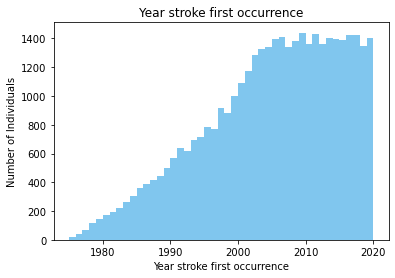

In [15]:
# Plot a histogram of Stroke year of first occurrence from individuals for whom it's not missing
sns.histplot(toy_data['stroke_year_first_occurrence'].dropna(), kde=False, bins=range(int(toy_data['stroke_year_first_occurrence'].min()), int(toy_data['stroke_year_first_occurrence'].max()) + 2),
            color='#56B4E9', linewidth=0)
plt.title('Year stroke first occurrence')
plt.xlabel('Year stroke first occurrence')
plt.ylabel('Number of Individuals')
plt.show()

***
**Question 3: make a bar chart of the number of TIA cases that occured before and after 2000.**

**Answer:**

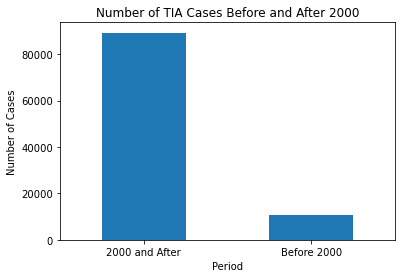

In [17]:
toy_data['Period'] = toy_data['TIA_year_first_occurrence'].apply(lambda x: 'Before 2000' if x < 2000 else '2000 and After')
case_counts = toy_data['Period'].value_counts()
case_counts.plot(kind='bar')
plt.title('Number of TIA Cases Before and After 2000')
plt.xlabel('Period')
plt.ylabel('Number of Cases')
plt.xticks(rotation=0)
plt.show()

***

We save the renamed dataframe for next section.

In [19]:
toy_data.to_csv('../data/toy_data_renamed.tsv', sep='\t', index=False)


# Exercise 2 - Use genetic data to validate the diagnoses by the different clinical datasets

Now let's see how strongly associated our different disease definitions are associated with genetic variants known to affect risk of these diseases. 

For stroke and TIA, a lot of genetic variants have been confidently associated with disease susceptibility (see https://www.ibdgenetics.org). So we have pre-calculated a genetic risk score (PRS). To understand PRS better, you can read more in [Sun et al. 2021](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003498).

The premise is that the participants diagnosed with TIA or stroke should have a higher genetic risk score than the average population, and thus changes in the distribution of scores between the different categories might help us infer whether it is appropiate to use one source of clinical data or both.

We will start by loading the genetic scores from a file. And note that in this section we will all use `sos` cells. When you answer questions in this section, please also set the kernel of your answer to `SoS` instead of `Python`.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # pretty plotting, similar to ggplot2
import matplotlib.pyplot as plt # base plots

import statsmodels.api as sm # similar to glm() in R
import statsmodels.formula.api as smf

from scipy.stats import norm
from scipy.stats import t
from sklearn.preprocessing import scale


PRS = pd.read_table("../data/toy_data_PRS.tsv", low_memory=False)
PRS.head()

,ID,TIA_PRS,stroke_PRS
0,100001,0.615897,0.663288
1,100015,0.487190,0.455392
2,100026,0.665074,0.313975
3,100029,0.733666,0.545491
4,100041,0.515659,0.431386


Now we can look at the mean of the genetic score distribution for each phenotype. To do this we need to import the `toy_data` again into the `SoS` kernel.

In [2]:
toy_data = pd.read_table("../data/toy_data_renamed.tsv", low_memory=False)

***
**Question 4: Can you transfer the `toy_data` from Python3 into `SoS` kernel directly, without loading it again? Hint: check [Magic %get](https://vatlab.github.io/sos-docs/doc/user_guide/multi_kernel_notebook.html).** (Please just write down the code below and don't run it to avoid unnecessary conflict.)

**Answer: %get toy_data from Python3**

***

What we want to do now is to evaluate whether the distribution of the genetic score varies per category, and how it compares with the population control group. For this we will compute mean genetic score and its 95% confidence interval for each diagnosis category. First let's combine the PRS data with the diagnosis categories we created before and define the categories.

In [3]:
df_PRS = pd.merge(PRS, toy_data, on='ID', how='left')
# define diagnosis category
df_PRS['TIA_first_occurrence_category'] = df_PRS['TIA_first_occurrence'].map({
    20: 'Death register only',
    21: 'Death register and other source(s)',
    30: 'Primary care only',
    31: 'Primary care and other source(s)',
    40: 'Hospital admissions data only',
    41: 'Hospital admissions data and other source(s)',
    50: 'Self-report only',
    51: 'Self-report and other source(s)'
}).fillna('control')

Then let's calculate the mean value and 95%CI for the PRS.

In [4]:
# TIA
grouped_TIA = df_PRS.groupby('TIA_first_occurrence_category')
df_PRS_means_TIA = grouped_TIA.agg(
    N=('TIA_PRS', 'size'),
    PRS_mean=('TIA_PRS', 'mean'),
    PRS_std=('TIA_PRS', 'std')
)
df_PRS_means_TIA['ci_low'] = df_PRS_means_TIA['PRS_mean'] - t.ppf(1 - 0.05 / 2, df_PRS_means_TIA['N'] - 1) * df_PRS_means_TIA['PRS_std'] / (df_PRS_means_TIA['N']**0.5)
df_PRS_means_TIA['ci_upper'] = df_PRS_means_TIA['PRS_mean'] + t.ppf(1 - 0.05 / 2, df_PRS_means_TIA['N'] - 1) * df_PRS_means_TIA['PRS_std'] / (df_PRS_means_TIA['N']**0.5)
df_PRS_means_TIA.reset_index(inplace=True)
df_PRS_means_TIA.rename(columns={'TIA_first_occurrence_category': 'category'}, inplace=True)

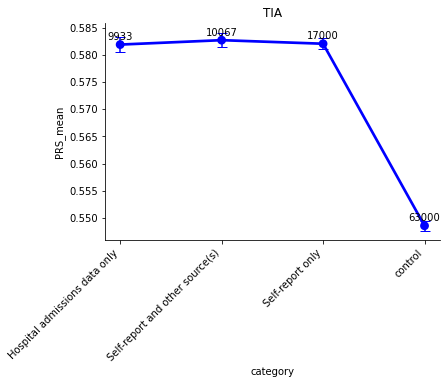

In [5]:
data = df_PRS_means_TIA
sns.pointplot(data=data, x='category', y='PRS_mean', color='blue', linestyle='none', errorbar=None)
plt.errorbar(data['category'], data['PRS_mean'], yerr=[data['PRS_mean'] - data['ci_low'], data['ci_upper'] - data['PRS_mean']], fmt='none', color='blue', capsize=5)


# Annotate with the number of participants
for i, row in data.iterrows():
    plt.text(row['category'], row['PRS_mean'] + 0.0005, str(row['N']), ha='center', va='bottom')

# Set the title for the subplot
plt.title('TIA')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Turn off grid
plt.grid(False)

# Set background to blank and draw axis lines
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

***
**Question 5: please draw the same plot for stroke. Note that please name the variables in the same way as we do to TIA, so your output would include a variable named `df_PRS_means_stroke`.**

**Answer:**

In [7]:
# define diagnosis category
df_PRS['stroke_first_occurrence_category'] = df_PRS['stroke_first_occurrence'].map({
    20: 'Death register only',
    21: 'Death register and other source(s)',
    30: 'Primary care only',
    31: 'Primary care and other source(s)',
    40: 'Hospital admissions data only',
    41: 'Hospital admissions data and other source(s)',
    50: 'Self-report only',
    51: 'Self-report and other source(s)'
}).fillna('control')

# stroke
grouped_stroke = df_PRS.groupby('stroke_first_occurrence_category')
df_PRS_means_stroke = grouped_stroke.agg(
    N=('stroke_PRS', 'size'),
    PRS_mean=('stroke_PRS', 'mean'),
    PRS_std=('stroke_PRS', 'std')
)
df_PRS_means_stroke['ci_low'] = df_PRS_means_stroke['PRS_mean'] - t.ppf(1 - 0.05 / 2, df_PRS_means_stroke['N'] - 1) * df_PRS_means_stroke['PRS_std'] / (df_PRS_means_stroke['N']**0.5)
df_PRS_means_stroke['ci_upper'] = df_PRS_means_stroke['PRS_mean'] + t.ppf(1 - 0.05 / 2, df_PRS_means_stroke['N'] - 1) * df_PRS_means_stroke['PRS_std'] / (df_PRS_means_stroke['N']**0.5)
df_PRS_means_stroke.reset_index(inplace=True)
df_PRS_means_stroke.rename(columns={'stroke_first_occurrence_category': 'category'}, inplace=True)

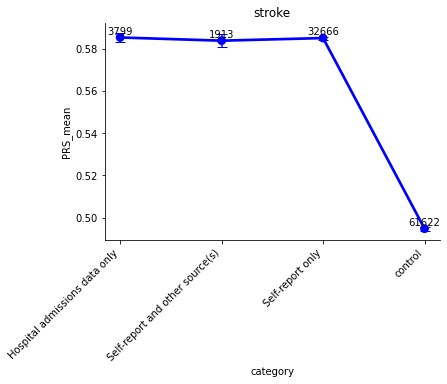

In [8]:
data = df_PRS_means_stroke
sns.pointplot(data=data, x='category', y='PRS_mean', color='blue', linestyle='none', errorbar=None)
plt.errorbar(data['category'], data['PRS_mean'], yerr=[data['PRS_mean'] - data['ci_low'], data['ci_upper'] - data['PRS_mean']], fmt='none', color='blue', capsize=5)


# Annotate with the number of participants
for i, row in data.iterrows():
    plt.text(row['category'], row['PRS_mean'] + 0.0005, str(row['N']), ha='center', va='bottom')

# Set the title for the subplot
plt.title('stroke')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Turn off grid
plt.grid(False)

# Set background to blank and draw axis lines
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

***

**Question 6: is there any shared pattern between TIA and stroke categories, and why is that? For each trait, which is the category with highest mean polygenic risk scores, and the one with the lowest?**

**Answer: Both TIA and stroke has PRS_mean around 0.58 for both hospital admission, self-report and other sources, and self-report only categories. This might because TIA and stroke are caused by similar underlying factors. For both TIA and stroke, self-report has the highest mean polygenic risk score. For TIA, hospital adimissions data only has the lowest mean risk score while for stroke, self-report and other sources has the lowest mean risk score.**

***

# Problem Solving

I am having trouble to select kernal for each cell as I don't have the scroll down list. I have to change the general kernal on the top right corner each time I want to change a language. I downloaded SoS under the conda environment, I am not sure if this is because of environment setting.